In [70]:
# Suppress warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from floris.tools import FlorisInterface
from floris import tools as wfct

# from flasc.model_tuning.floris_tuner import FlorisTuner
import flasc.floris_tools as ftools
import flasc.model_tuning.floris_tuning as ft
## Tune wake steering on total uplift
from flasc.energy_ratio import total_uplift as tup
from flasc.model_tuning.tuner_utils import set_fi_param
from flasc.visualization import plot_layout_with_waking_directions


warnings.filterwarnings('ignore')


# Parameters

In [71]:
model_to_tune_to = 'emgauss' # gch, turbopark, emgauss
n_row_x = 3 # Define the number of turbine rows in the x direction
n_row_y = 3 # Define the number of turbine rows in the y direction (should be odd)
D_between_turbines_x = 7 # Distance between turbines
D_between_turbines_y = 10 # Distance between turbines

if n_row_y % 2 == 0:
    warnings.warn('Even number will be weird')


In [72]:
# Parameters about timing and grouping
points_per_group = 10


## Load FLORIS

In [73]:
# Load the FLORIS models for GCH and EMG
file_path = Path.cwd()

# Load the model to tune to (fi_benchmark)
fi_path = file_path / f"../floris_input_artificial/{model_to_tune_to}.yaml"
fi_benchmark = wfct.floris_interface.FlorisInterface(fi_path)

# Load the emgauss model
fi_path = file_path / "../floris_input_artificial/emgauss.yaml"
fi_emg = wfct.floris_interface.FlorisInterface(fi_path)



# Generate data to tune to

In [74]:
# Define a layout of num_turbines turbines arranged in a grid
num_turbines = n_row_x * n_row_y
D = 126

layout_x = []
layout_y = []

for i in range(n_row_x):
    for j in range(n_row_y):
        layout_x.append(i * D * D_between_turbines_x)
        layout_y.append(j * D * D_between_turbines_y)


print(layout_x)
print(layout_y)

[0, 0, 0, 882, 882, 882, 1764, 1764, 1764]
[0, 1260, 2520, 0, 1260, 2520, 0, 1260, 2520]


In [75]:
# Identify the indexes of the reference turbine, the control turbine, the single_wake turbine and the deep_wake turbine
ref_idx = 0
control_idx = int(np.floor(n_row_y / 2))
single_wake_idx = int(np.floor(n_row_y / 2) + n_row_y)
deep_wake_idx = int(num_turbines - (np.floor(n_row_y / 2)) - 1)

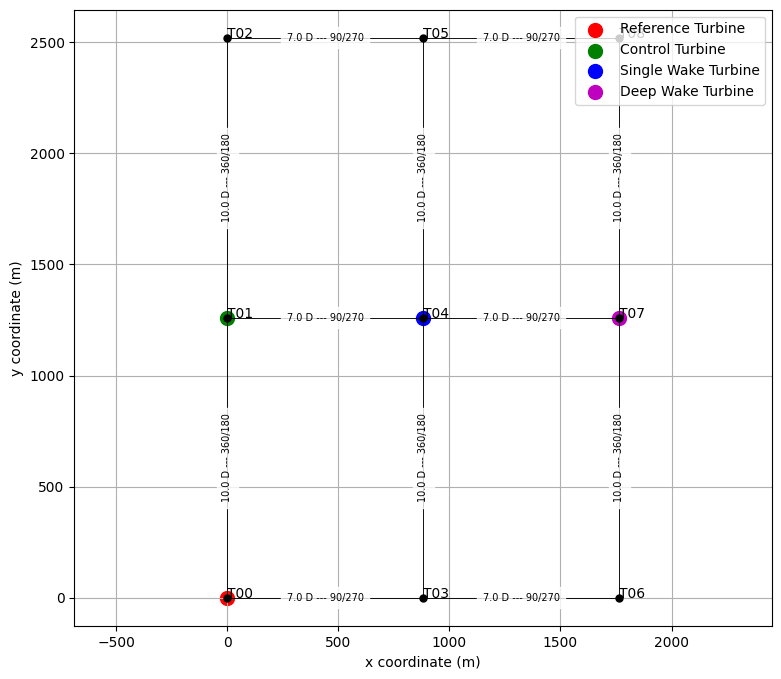

In [76]:
# Set the layout and show the locations of special turbines 
fi_benchmark.reinitialize(layout_x=layout_x, layout_y=layout_y)
fi_emg.reinitialize(layout_x=layout_x, layout_y=layout_y)

fig, ax = plt.subplots(figsize=(9,8))
plot_layout_with_waking_directions(fi_benchmark,
                                   limit_dist_D=D_between_turbines_y*1.2,
                                   ax=ax
                                   )

# Show the special turbine locations
ax.scatter(layout_x[ref_idx],layout_y[ref_idx],color='r',marker='o',s=100,label='Reference Turbine')
ax.scatter(layout_x[control_idx],layout_y[control_idx],color='g',marker='o',s=100,label='Control Turbine')
ax.scatter(layout_x[single_wake_idx],layout_y[single_wake_idx],color='b',marker='o',s=100,label='Single Wake Turbine')
ax.scatter(layout_x[deep_wake_idx],layout_y[deep_wake_idx],color='m',marker='o',s=100,label='Deep Wake Turbine')
ax.legend()

## Generate a time history of wind speed conditions to generate around a sector of west winds

Num Points 10000


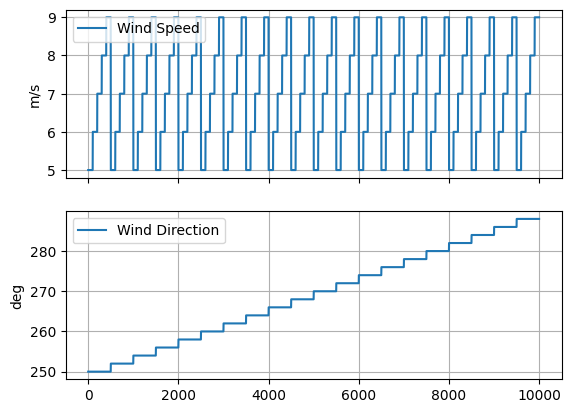

In [77]:
# Create a time history of points where the wind speed and wind direction step different combinations
ws_points = np.arange(5.0,10.0,1.0)
wd_points = np.arange(250.0, 290.0, 2,)
num_points_per_combination = 10 * points_per_group # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
wd_array = []
ws_array = []
for wd in wd_points:
    for ws in ws_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f'Num Points {len(t)}')

fig, axarr = plt.subplots(2,1,sharex=True)
axarr[0].plot(t, ws_array,label='Wind Speed')
axarr[0].set_ylabel('m/s')
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array,label='Wind Direction')
axarr[1].set_ylabel('deg')
axarr[1].legend()
axarr[1].grid(True)

In [78]:
total_number_of_points = len(ws_array)
total_number_of_points

10000

# Simulate benchmark FLORIS and save power in kW

In [79]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fi_benchmark.reinitialize(wind_speeds=ws_array, wind_directions=wd_array, time_series=True)
fi_benchmark.calculate_wake()
power_baseline = fi_benchmark.get_turbine_powers().squeeze() / 1000.



In [80]:
# Set up yaw angles to be positive for winds over 250
yaw_angles = np.zeros([len(ws_array),1,num_turbines])
yaw_angles[np.array(wd_array)>=25,:,control_idx] = 25 # Set control turbine yaw angles to 25 deg


In [81]:
fi_benchmark.calculate_wake(yaw_angles=yaw_angles)
power_wakesteering = fi_benchmark.get_turbine_powers().squeeze() / 1000.

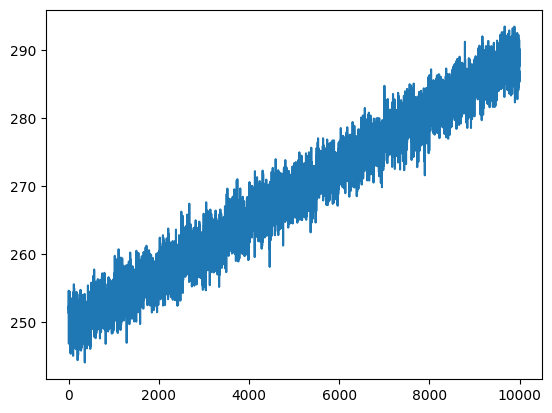

In [82]:
# Recompute assuming some random perturbation of the wd signal
wd_std_benchmark = 2.0
wd_array_noisy = wd_array + np.random.randn(len(wd_array)) * wd_std_benchmark,
wd_array_noisy = wd_array_noisy[0]
plt.plot(wd_array_noisy)

In [83]:
fi_benchmark.reinitialize(wind_speeds=ws_array, wind_directions=wd_array_noisy, time_series=True)
fi_benchmark.calculate_wake()
power_baseline_noisy = fi_benchmark.get_turbine_powers().squeeze() / 1000.


fi_benchmark.calculate_wake(yaw_angles=yaw_angles)
power_wakesteering_noisy = fi_benchmark.get_turbine_powers().squeeze() / 1000.

## Assemble the data into pandas dataframes

In [84]:
def get_df(data, wd_, ws_):

    # Define the power column names
    pow_cols = ['pow_%03d' % t for t in range(num_turbines)]
    
    # Build the dataframe
    df_ = pd.DataFrame(data=data, columns=pow_cols)

    # Add ws and wd and pow_ref
    df_ = (df_.assign(
        wd = wd_, # + np.random.randn(len(wd_array))* wd_noise,
        ws = ws_ # + np.random.randn(len(ws_array))* ws_noise
    ))

    # Aggregate every 10 points together
    df_['group'] = (df_.index // points_per_group)

    # Group the DataFrame by the 'group' column and calculate the mean
    df_ = df_.groupby('group').agg('mean')

    # Reset the index to have a clean index
    df_ = df_.reset_index(drop=True)
    # df_['pow_ref'] = df_['pow_%03d' % ref_idx]

    # Reorganize columns

    df_ = df_[['wd','ws'] + pow_cols]

    return df_

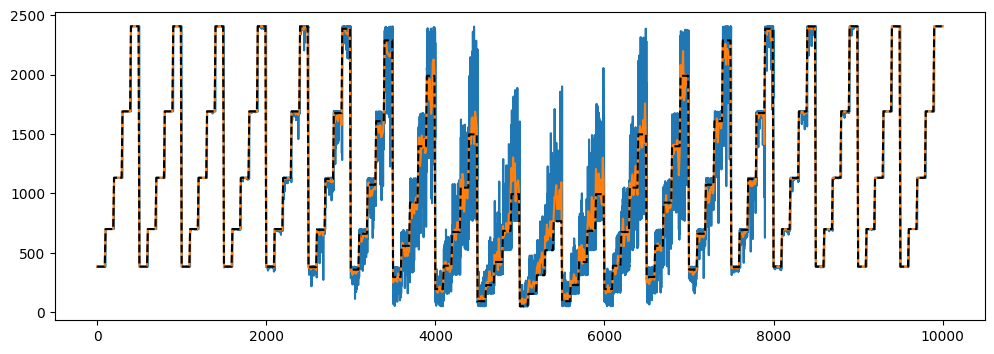

In [85]:
df_baseline = get_df(power_baseline, wd_array, ws_array)
df_wakesteering = get_df(power_wakesteering, wd_array, ws_array)
df_baseline_noisy = get_df(power_baseline_noisy, wd_array_noisy, ws_array)
df_wakesteering_noisy = get_df(power_wakesteering_noisy, wd_array_noisy, ws_array)
# df_wakesteering = get_df(power_wakesteering)

# # Get noisy versions
# df_baseline_noisy = get_df(power_baseline, wd_noise=2., ws_noise=0.)
# df_wakesteering_noisy = get_df(power_wakesteering, wd_noise=2., ws_noise=0.)

n_row = power_baseline.shape[0]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(list(range(n_row)),power_baseline_noisy[:,single_wake_idx])
ax.plot(np.arange(0,n_row,10),df_baseline_noisy['pow_%03d' % single_wake_idx])
ax.plot(np.arange(0,n_row,10),df_baseline['pow_%03d' % single_wake_idx],'k--')

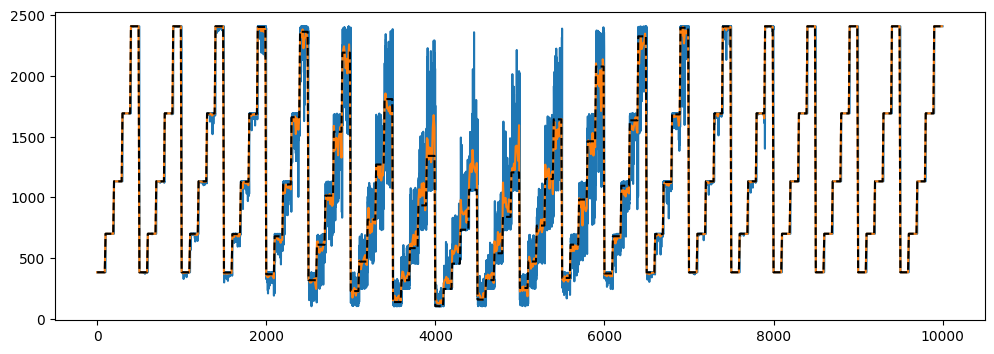

In [87]:
n_row = power_baseline.shape[0]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(list(range(n_row)),power_wakesteering_noisy[:,single_wake_idx])
ax.plot(np.arange(0,n_row,10),df_wakesteering_noisy['pow_%03d' % single_wake_idx])
ax.plot(np.arange(0,n_row,10),df_wakesteering['pow_%03d' % single_wake_idx],'k--')

In [86]:
# Similarly average the yaw angle matrices along every 10
yaw_angles_reshaped = yaw_angles.reshape(total_number_of_points//points_per_group, points_per_group, 1, yaw_angles.shape[2])
yaw_angles = np.mean(yaw_angles_reshaped, axis=1)



In [88]:
# Save the yaw angles
yaw_angles_base = 0 * yaw_angles
yaw_angels_wakesteering = yaw_angles

## Tune Wake Expansion (First Index) to baseline (non-noisy) data

In [89]:
wake_expansion_rates = np.arange(start=0.0005, 
                                   stop=0.025,
                                   step=0.0005)

In [90]:
df_scada = df_baseline.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi_emg,
    param_idx=0,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx]
)
print(floris_wake_losses, scada_wake_loss)

[17.45471208 17.39184609 17.33001988 17.2660059  17.20079455 17.13408884
 17.06766907 17.00103717 16.93299342 16.86497758 16.79450463 16.72453238
 16.65506253 16.58494077 16.5130108  16.43907024 16.36432723 16.28738129
 16.21113745 16.13560645 16.0606338  15.98385393 15.90700637 15.82869581
 15.75105275 15.67424798 15.59828266 15.5231567  15.44783236 15.37177145
 15.29540386 15.21930565 15.14224613 15.06548169 14.98934919 14.91324284
 14.83704835 14.76150516 14.68641411 14.61121037 14.5369417  14.46359741
 14.39061613 14.31800031 14.2452501  14.17342268 14.10202497 14.03036455
 13.95961497] 16.135606449892187


Text(0, 0.5, 'Percent Wake Loss')

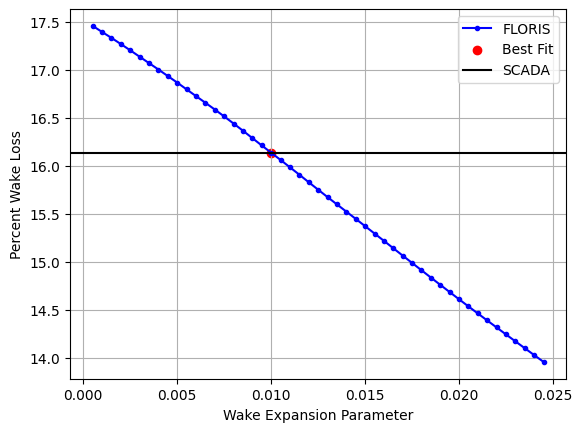

In [91]:

fig, ax = plt.subplots()
best_param = ft.select_best_velocity_parameter(floris_wake_losses, 
                   scada_wake_loss,
                   wake_expansion_rates, 
                   ax=ax)
ax.set_xlabel('Wake Expansion Parameter')
ax.set_ylabel('Percent Wake Loss')

In [92]:
# Apply the best fit
fi_emg = set_fi_param(fi_emg, 
                      ['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                      param_idx=0,
                      value=best_param)

In [93]:
print(fi_emg.floris.as_dict()['wake']['wake_velocity_parameters']['empirical_gauss']['wake_expansion_rates'])

[0.01, 0.005]


## Retune with noisy data

In [94]:
# Make a copy for the noisy fi_emg model
fi_emg_noisy = fi_emg.copy()

In [95]:
print(fi_emg_noisy.floris.as_dict()['wake']['wake_velocity_parameters']['empirical_gauss']['wake_expansion_rates'])

[0.01, 0.005]


In [96]:
df_scada = df_baseline_noisy.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi_emg_noisy,
    param_idx=0,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx]
)
print(floris_wake_losses, scada_wake_loss)

[17.49185724 17.4273998  17.36327103 17.29808862 17.23226791 17.16579984
 17.09891127 17.03031448 16.96076838 16.89041836 16.81875927 16.7469827
 16.6751607  16.60339428 16.53072176 16.4565374  16.3809561  16.30469319
 16.22845474 16.15200113 16.07539034 15.99847297 15.92148779 15.84404449
 15.76697708 15.69023132 15.61379221 15.53724482 15.45917639 15.38067054
 15.30243545 15.22460241 15.14726437 15.07032302 14.99333508 14.91621623
 14.83947833 14.76337713 14.68798276 14.61327076 14.53916817 14.46562358
 14.39205982 14.31809257 14.24419605 14.17117473 14.09874352 14.02701891
 13.95569355] 16.170287634058134


Text(0, 0.5, 'Percent Wake Loss')

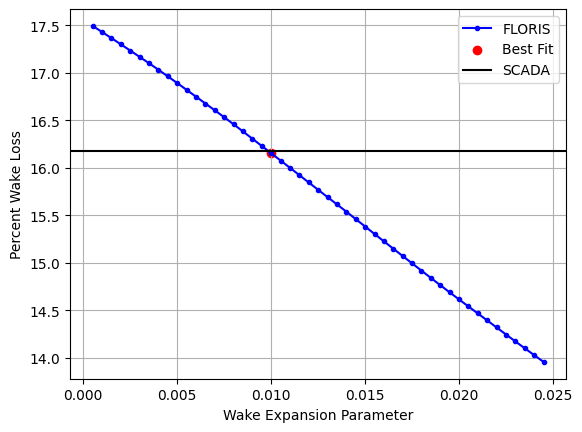

In [97]:

fig, ax = plt.subplots()
best_param = ft.select_best_velocity_parameter(floris_wake_losses, 
                   scada_wake_loss,
                   wake_expansion_rates, 
                   ax=ax)
ax.set_xlabel('Wake Expansion Parameter')
ax.set_ylabel('Percent Wake Loss')

In [98]:
# Apply the best fit
fi_emg_noisy = set_fi_param(fi_emg_noisy, 
                      ['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                      param_idx=0,
                      value=best_param)

## Identify wd_std

In [99]:
min_wd = np.floor(np.min([df_baseline.wd.min(), df_baseline_noisy.wd.min()]))
max_wd = np.ceil(np.max([df_baseline.wd.max(), df_baseline_noisy.wd.max()]))

min_ws = np.floor(np.min([df_baseline.ws.min(), df_baseline_noisy.ws.min()]))
max_ws = np.ceil(np.max([df_baseline.ws.max(), df_baseline_noisy.ws.max()]))

In [100]:
# Make approximate tables
wd_array = np.arange(min_wd, max_wd, 1.)
ws_array = np.arange(min_ws, max_ws, 1.)

df_approx = ftools.calc_floris_approx_table(fi_emg, 
                                            wd_array=wd_array,
                                            ws_array=ws_array,
                                            ti_array = np.array([0.1]))

Generating a df_approx table of FLORIS solutions covering a total of 168 cases.
Finished calculating the FLORIS solutions for the dataframe.


In [101]:
df_approx_noisy = ftools.calc_floris_approx_table(fi_emg_noisy, 
                                            wd_array=wd_array,
                                            ws_array=ws_array,
                                            ti_array = np.array([0.1]))

Generating a df_approx table of FLORIS solutions covering a total of 168 cases.
Finished calculating the FLORIS solutions for the dataframe.


In [102]:
# Select the values to check
wd_std_range = [0, 1, 2, 3, 4, 5]

In [103]:
# Evaluate
df_scada = df_baseline.copy()
er_error, df_list = ft.sweep_wd_std_for_er(
        wd_std_range,
        df_scada,
        df_approx,
        ref_turbines=[ref_idx],
        test_turbines=[single_wake_idx]
    )

   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated so

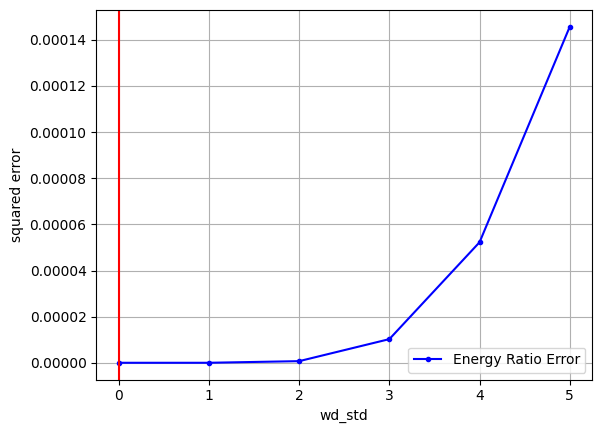

In [104]:
# Select the best result
fig, ax = plt.subplots()
best_param = ft.select_best_wd_std(er_error, 
                   wd_std_range,
                   ax=ax)


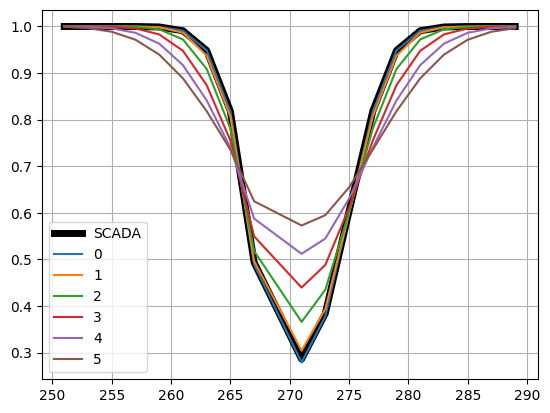

In [105]:
# Plot the values
fig, ax = plt.subplots()

ax.plot(df_list[0]['wd_bin'],df_list[0]['SCADA'].values, color='k',lw=5,label='SCADA')

for i, wd_std in enumerate(wd_std_range):
    ax.plot(df_list[i]['wd_bin'],df_list[i]['FLORIS'].values, label=wd_std)

ax.grid()
ax.legend()

#### Repeat with noisy data

In [106]:
df_scada = df_baseline_noisy.copy()
er_error, df_list = ft.sweep_wd_std_for_er(
        wd_std_range,
        df_scada,
        df_approx_noisy,
        ref_turbines=[ref_idx],
        test_turbines=[single_wake_idx]
    )

   minimum/maximum value in df:        (248.983, 289.440)
   minimum/maximum value in df_approx: (248.000, 289.000)
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
   minimum/maximum value in df:        (248.983, 289.440)
   minimum/maximum value in df_approx: (248.000, 289.000)
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum value in df_approx: (5.000, 8.000)
Mapping the precalculated solutions from FLORIS to the dataframe...
  Creating a gridded interpolant with interpolation method 'linear'.
     Interpolating pow for all turbines...
   minimum/maximum value in df:        (248.983, 289.440)
   minimum/maximum value in df_approx: (248.000, 289.000)
   minimum/maximum value in df:        (5.000, 9.000)
   minimum/maximum val

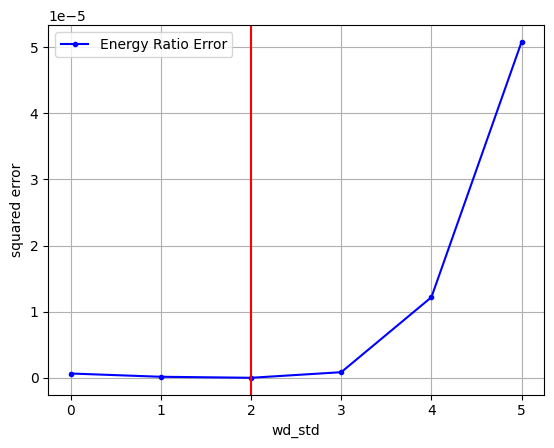

In [107]:
# Select the best result
fig, ax = plt.subplots()
best_param = ft.select_best_wd_std(er_error, 
                   wd_std_range,
                   ax=ax)

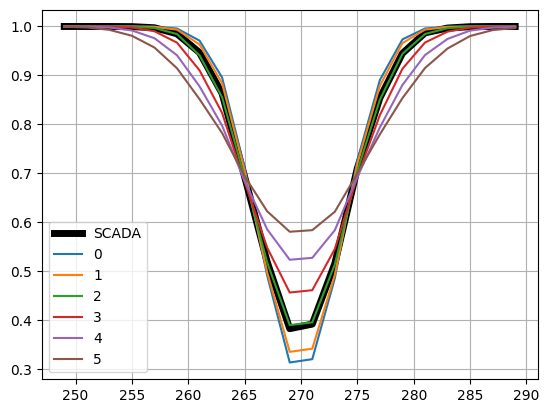

In [108]:
# Plot the values
fig, ax = plt.subplots()

ax.plot(df_list[0]['wd_bin'],df_list[0]['SCADA'].values, color='k',lw=5,label='SCADA')

for i, wd_std in enumerate(wd_std_range):
    ax.plot(df_list[i]['wd_bin'],df_list[i]['FLORIS'].values, label=wd_std)

ax.grid()
ax.legend()

In [109]:
hor_def_gains = np.arange(start=0.5, 
                                   stop=5,
                                   step=0.5)

In [110]:
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter = ['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_baseline,
    df_scada_wakesteering_in=df_wakesteering,
    fi_in=fi_emg,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx],
    yaw_angles_wakesteering=yaw_angles,
)

In [111]:
floris_uplifts, scada_uplift

(array([4.64280975, 4.64087771, 4.63314467, 4.59437604, 4.55972772,
        4.51527998, 4.44636411, 4.37233955, 4.29937435]),
 4.515279982716216)

Text(0, 0.5, 'Percent Uplift')

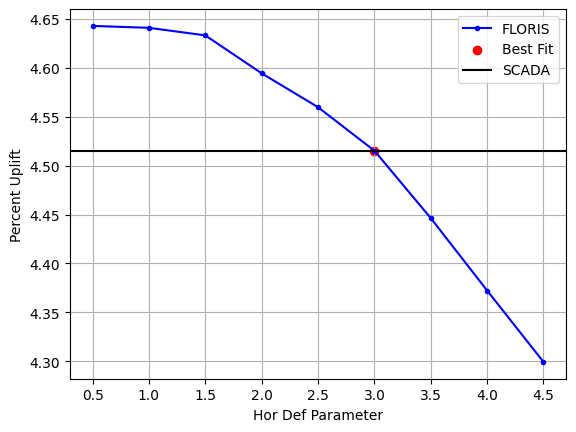

In [112]:

fig, ax = plt.subplots()
best_param = ft.select_best_velocity_parameter(floris_uplifts, 
                   scada_uplift,
                   hor_def_gains, 
                   ax=ax)
ax.set_xlabel('Hor Def Parameter')
ax.set_ylabel('Percent Uplift')

In [113]:
## Repeat for noisy
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter = ['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_baseline_noisy,
    df_scada_wakesteering_in=df_wakesteering_noisy,
    fi_in=fi_emg_noisy,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx],
    yaw_angles_wakesteering=yaw_angles,
)

Text(0, 0.5, 'Percent Uplift')

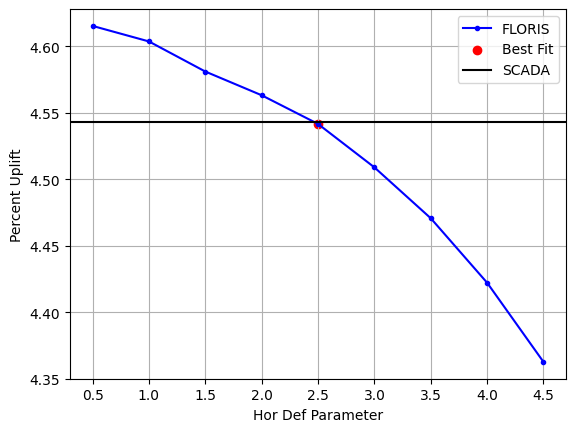

In [114]:

fig, ax = plt.subplots()
best_param = ft.select_best_velocity_parameter(floris_uplifts, 
                   scada_uplift,
                   hor_def_gains, 
                   ax=ax)
ax.set_xlabel('Hor Def Parameter')
ax.set_ylabel('Percent Uplift')